In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.model_selection import GroupShuffleSplit
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import callbacks
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
# Set Matplotlib defaults
plt.rc('figure', autolayout=True)
plt.rc('axes', labelweight='bold', labelsize='large',
        titleweight='bold', titlesize=18, titlepad=10)

/var/folders/cm/t16gz6kd6mvdqrhqvcg9f1fh0000gn/T/ipykernel_46895/699743346.py:10: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


In [2]:
data = pd.read_csv('spotify.csv')

X = data.copy().dropna()
y = X.pop('track_popularity')
artists = X['track_artist']

features_num = ['danceability', 'energy', 'key', 'loudness', 'mode',
                'speechiness', 'acousticness', 'instrumentalness',
                'liveness', 'valence', 'tempo', 'duration_ms']

features_cat = ['playlist_genre']

preprocessor = make_column_transformer(
    (StandardScaler(), features_num),
    (OneHotEncoder(), features_cat),
)

# We'll do a "grouped" split to keep all of an artist's songs in one
# split or the other. This is to help prevent signal leakage.
def group_split(X, y, group, train_size=0.75):
    splitter = GroupShuffleSplit(train_size=train_size)
    train, test = next(splitter.split(X, y, groups= group))
    return(X.iloc[train], X.iloc[test], y.iloc[train], y.iloc[test])

X_train, X_valid, y_train, y_valid = group_split(X, y, artists)

X_train = preprocessor.fit_transform(X_train)
X_valid = preprocessor.transform(X_valid)
y_train = y_train / 100 # popularity is on a scale 0-100, so this rescales to 0-1
y_valid = y_valid / 100

input_shape = [X_train.shape[1]]
print("Input shape: {}".format(input_shape))

Input shape: [18]


2023-09-16 18:47:31.425028: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Minimum Validation Loss: 0.1946


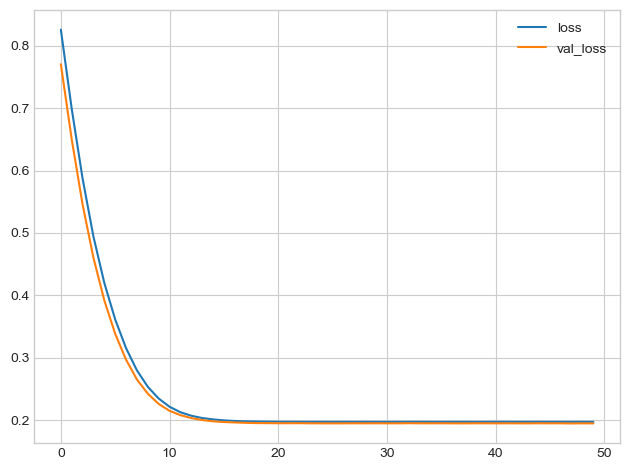

In [3]:
model = keras.Sequential([
    layers.Dense(1, input_shape=input_shape),
])
model.compile(
    optimizer = 'adam',
    loss ='mae'
)
history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=512,
    epochs=50,
    verbose=0 # supress output since we'll plot the curves
)
history_df = pd.DataFrame(history.history)
history_df.loc[0:, ['loss', 'val_loss']].plot()
print("Minimum Validation Loss: {:0.4f}".format(history_df['val_loss'].min()));

Minimum Validation Loss: 0.1946


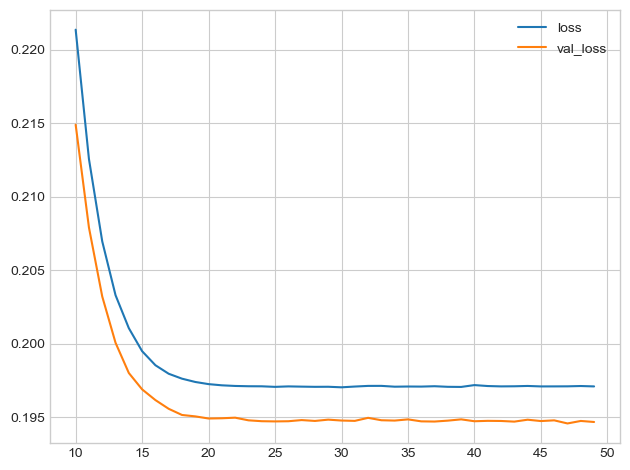

In [4]:
# Start the plot at epoch 10
history_df.loc[10:, ['loss', 'val_loss']].plot()
print("Minimum Validation Loss: {:0.4f}".format(history_df['val_loss'].min()))

Epoch 1/50
49/49 [==============================] - 1s 5ms/step - loss: 0.2196 - val_loss: 0.2018
Epoch 2/50
49/49 [==============================] - 0s 3ms/step - loss: 0.1995 - val_loss: 0.1986
Epoch 3/50
49/49 [==============================] - 0s 3ms/step - loss: 0.1952 - val_loss: 0.1965
Epoch 4/50
49/49 [==============================] - 0s 4ms/step - loss: 0.1928 - val_loss: 0.1967
Epoch 5/50
49/49 [==============================] - 0s 4ms/step - loss: 0.1911 - val_loss: 0.1967
Epoch 6/50
49/49 [==============================] - 0s 4ms/step - loss: 0.1886 - val_loss: 0.1955
Epoch 7/50
49/49 [==============================] - 0s 4ms/step - loss: 0.1873 - val_loss: 0.1956
Epoch 8/50
49/49 [==============================] - 0s 4ms/step - loss: 0.1869 - val_loss: 0.1960
Epoch 9/50
49/49 [==============================] - 0s 4ms/step - loss: 0.1860 - val_loss: 0.1974
Epoch 10/50
49/49 [==============================] - 0s 4ms/step - loss: 0.1846 - val_loss: 0.1953
Epoch 11/50
49/49 [

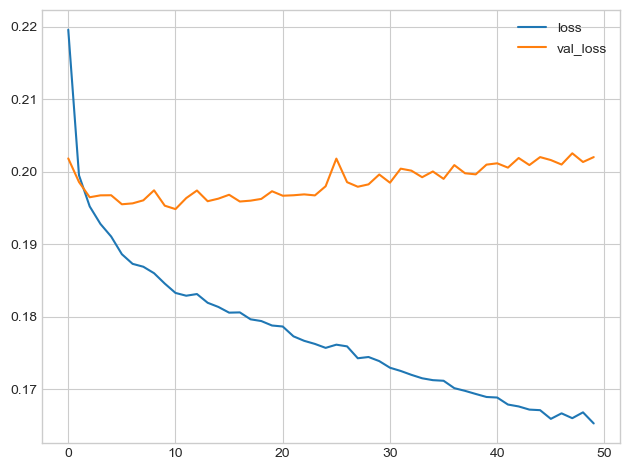

In [5]:
model = keras.Sequential([
    layers.Dense(128, activation='relu', input_shape=input_shape),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
])
model.compile(
    optimizer='adam',
    loss ='mae',
)
history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size = 512,
    epochs=50,
)
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot()
print("Minimum Validation Loss: {:0.4f}".format(history_df['val_loss'].min()));

In [6]:
from keras import callbacks

# Define an early stopping callback
early_stopping = callbacks.EarlyStopping(
    patience  = 5,
    min_delta = 0.001 ,
    restore_best_weights = True ,
)

Epoch 1/50
49/49 [==============================] - 1s 8ms/step - loss: 0.2468 - val_loss: 0.2063
Epoch 2/50
49/49 [==============================] - 0s 4ms/step - loss: 0.2032 - val_loss: 0.2000
Epoch 3/50
49/49 [==============================] - 0s 4ms/step - loss: 0.1972 - val_loss: 0.1987
Epoch 4/50
49/49 [==============================] - 0s 3ms/step - loss: 0.1942 - val_loss: 0.1966
Epoch 5/50
49/49 [==============================] - 0s 3ms/step - loss: 0.1918 - val_loss: 0.1975
Epoch 6/50
49/49 [==============================] - 0s 3ms/step - loss: 0.1905 - val_loss: 0.1969
Epoch 7/50
49/49 [==============================] - 0s 3ms/step - loss: 0.1889 - val_loss: 0.1963
Epoch 8/50
49/49 [==============================] - 0s 4ms/step - loss: 0.1877 - val_loss: 0.1956
Epoch 9/50
49/49 [==============================] - 0s 4ms/step - loss: 0.1866 - val_loss: 0.1958
Epoch 10/50
49/49 [==============================] - 0s 4ms/step - loss: 0.1864 - val_loss: 0.1961
Epoch 11/50
49/49 [

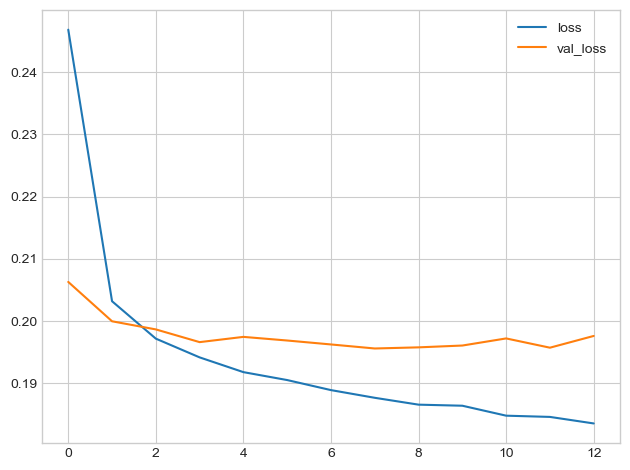

In [7]:
model = keras.Sequential([
    layers.Dense(128, activation='relu', input_shape=input_shape),
    layers.Dense(64, activation ='relu'),
    layers.Dense(1)
])
model.compile(
    optimizer = 'adam',
    loss = 'mae'
)
history = model.fit(
    X_train , y_train,
    validation_data=(X_valid, y_valid),
    batch_size=512,
    epochs=50,
    callbacks=[early_stopping]
)
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot()
print("Minimum Validation Loss: {:00.4f}".format(history_df['val_loss'].min()));